
Predicting telecom customer churn using TensorFlow, featuring detailed EDA, preprocessing, model training, and results visualization.

 # 🧠 Customer Churn Prediction — Jupyter Notebook
---



In [3]:
# 🛠️ Step 0: Setup Libraries
# Import required libraries for data analysis, visualization, ML, and TensorFlow model building

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE

# Set random seed for reproducibility
tf.random.set_seed(42)

# Display settings
pd.set_option('display.max_columns', None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


<Axes: title={'center': 'Churn Distribution'}, xlabel='Churn'>

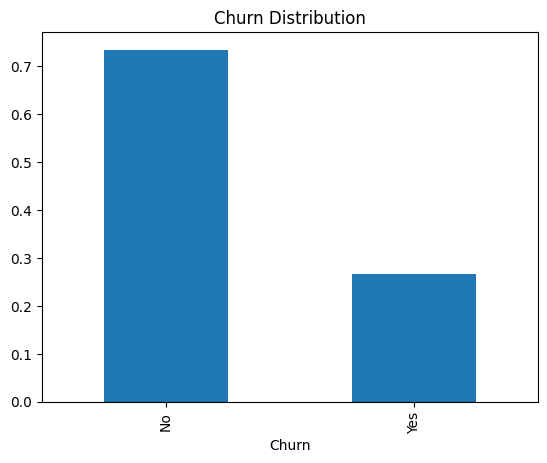

In [4]:
# 📋 Step 1: Load Dataset
# Load the Telco Customer Churn dataset from Kaggle

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Basic data overview
df.head()
df.info()

# Plot class imbalance to visualize Churn ratio
df['Churn'].value_counts(normalize=True).plot(kind='bar', title='Churn Distribution')

Text(0.5, 1.0, 'Internet Service vs Churn')

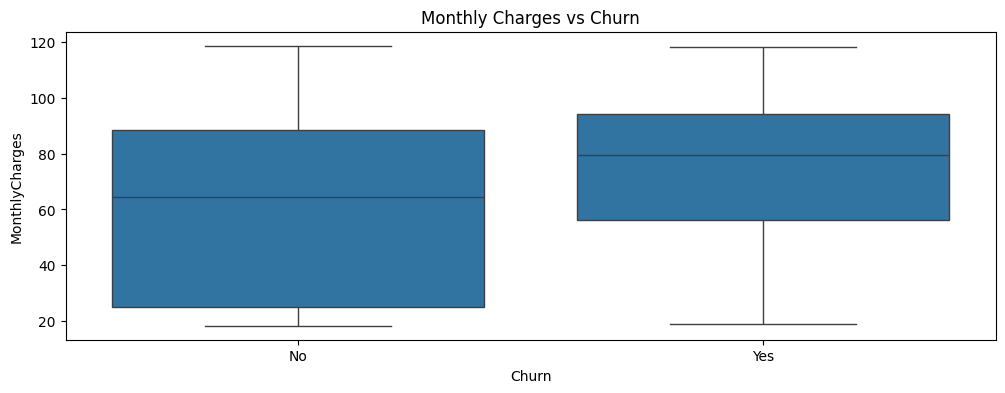

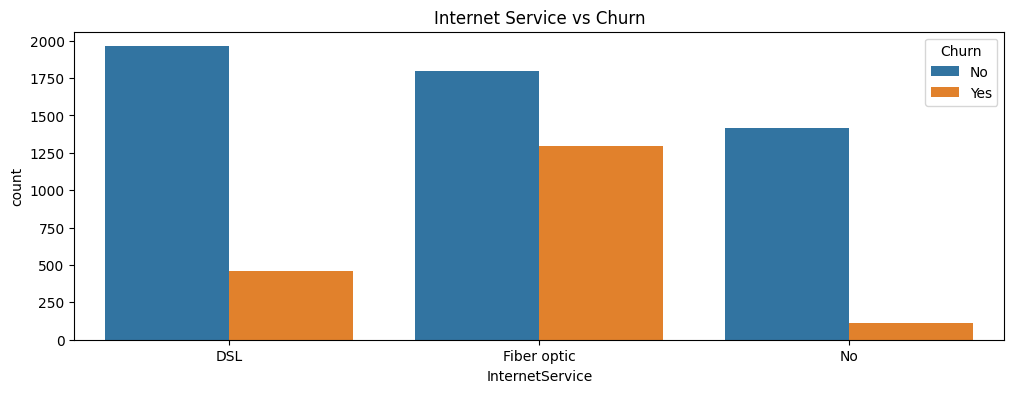

In [5]:
# 🎨 Step 2: Exploratory Data Analysis (EDA)
# Explore relationships between variables and Churn

# 1️⃣ Monthly Charges vs Churn
plt.figure(figsize=(12,4))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges vs Churn')

# 2️⃣ Internet Service vs Churn
plt.figure(figsize=(12,4))
sns.countplot(x='InternetService', hue='Churn', data=df)
plt.title('Internet Service vs Churn')

In [6]:
# 🔍 Step 3: Data Preprocessing

# Step 3.1: Clean TotalCharges
# Some entries in TotalCharges are blank — convert them to numeric and drop NA
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)  # drops rows with NA in TotalCharges or other columns at this point

# Step 3.2: Encode Categorical Variables
# We use One-Hot Encoding (OHE) to convert categorical variables to numerical ones

# Select all categorical columns except customerID and Churn
cat_cols = df.select_dtypes(include='object').drop(['customerID','Churn'], axis=1)

# Initialize OneHotEncoder
ohe = OneHotEncoder(sparse=False)

# Fit and transform categorical columns
cat_enc = ohe.fit_transform(cat_cols)

# Convert encoded data to DataFrame
cat_df = pd.DataFrame(cat_enc, columns=ohe.get_feature_names_out(), index=cat_cols.index)

# Step 3.3: Combine numerical + categorical features into one dataframe
data = pd.concat([df[['tenure','MonthlyCharges','TotalCharges']], cat_df], axis=1)

# Step 3.4: Encode Target Variable
# Convert "Yes" to 1 and "No" to 0 for binary classification
data['Churn'] = (df['Churn']=='Yes').astype(int)

# 🚨 Important: Drop rows with any remaining NaN values (safe for SMOTE)
data = data.dropna()

# 🔍 Check again if any NaN remains in the dataset (debug check)
print('Total NaN values after dropping:', data.isnull().sum().sum())  # should print 0

# Step 3.5: Split Features and Target
X = data.drop('Churn', axis=1)
y = data['Churn']

# Step 3.6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3.7: Handle Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Debug checks
print("Original training set class distribution:", y_train.value_counts())
print("Resampled training set class distribution:", y_train_sm.value_counts())

C:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Total NaN values after dropping: 0
Original training set class distribution: Churn
0    4130
1    1495
Name: count, dtype: int64
Resampled training set class distribution: Churn
1    4130
0    4130
Name: count, dtype: int64


In [7]:
# 🔢 Step 4: Feature Scaling
# Standardize numerical features so that the model can converge faster

scaler = StandardScaler()
X_train_sm = scaler.fit_transform(X_train_sm)
X_test = scaler.transform(X_test)

In [8]:
print(X_test)

[[ 1.384861   -1.49472685 -0.25481406 ... -0.49992465 -0.88268407
  -0.53434611]
 [-0.36830544 -1.50517032 -0.72964521 ... -0.49992465 -0.88268407
  -0.53434611]
 [-0.61875779  1.1944688  -0.32024716 ...  2.15788153 -0.88268407
  -0.53434611]
 ...
 [-0.07611103 -0.41382685 -0.23123064 ... -0.49992465 -0.88268407
   1.99564222]
 [ 0.29956749  1.49210793  0.81528641 ... -0.49992465 -0.88268407
  -0.53434611]
 [ 1.84402364 -1.49124569 -0.09158655 ... -0.49992465 -0.88268407
  -0.53434611]]


In [9]:
print(X_train_sm)

[[ 0.63350395 -0.65750801  0.00849973 ... -0.49992465 -0.88268407
  -0.53434611]
 [-1.03617837 -0.50607757 -0.85668398 ...  2.15788153 -0.88268407
  -0.53434611]
 [ 1.13440865  0.34158475  1.1003272  ... -0.49992465  1.25455738
  -0.53434611]
 ...
 [ 0.38305161  1.03571572  0.7177391  ...  0.34384254  0.5760526
  -0.53434611]
 [-1.11966249  0.77839948 -0.90178905 ... -0.49992465  1.25455738
  -0.53434611]
 [-0.82746808  0.48911191 -0.63507955 ... -0.49992465 -0.88268407
  -0.53434611]]


In [10]:
# 🧠 Step 5: Build TensorFlow Model

# Model Explanation:
# We use a **Feed-Forward Neural Network** (also called Multilayer Perceptron) with:
# - Input Layer
# - Hidden Layer 1 → 64 neurons + ReLU activation
# - Dropout → helps prevent overfitting
# - Hidden Layer 2 → 32 neurons + ReLU activation
# - Dropout → again for regularization
# - Output Layer → 1 neuron + Sigmoid activation to output probability of churn

# Why Neural Network?
# - Flexible to model complex patterns
# - Handles both linear and nonlinear relationships
# - Generalizes well on unseen data if regularized properly

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_sm.shape[1],)),
    tf.keras.layers.Dropout(0.3),  # 30% Dropout

    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),  # 30% Dropout

    tf.keras.layers.Dense(1, activation='sigmoid')  # Outputs probability between 0 and 1
])

# Compile Model
model.compile(
    optimizer='adam',                      # Adam optimizer — adaptive learning rate
    loss='binary_crossentropy',            # Loss function for binary classification
    metrics=['accuracy', tf.keras.metrics.AUC()]  # Evaluate with Accuracy + AUC
)

# Train the model
history = model.fit(
    X_train_sm, y_train_sm,
    epochs=30,                  # Number of training iterations
    validation_split=0.1,       # Reserve 10% of training data for validation
    batch_size=32               # Number of samples processed before model update
)

C:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6790 - auc: 0.7331 - loss: 0.6053 - val_accuracy: 0.7554 - val_auc: 0.0000e+00 - val_loss: 0.5396
Epoch 2/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7581 - auc: 0.8341 - loss: 0.4997 - val_accuracy: 0.7482 - val_auc: 0.0000e+00 - val_loss: 0.5436
Epoch 3/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7652 - auc: 0.8431 - loss: 0.4885 - val_accuracy: 0.7530 - val_auc: 0.0000e+00 - val_loss: 0.5349
Epoch 4/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7699 - auc: 0.8469 - loss: 0.4809 - val_accuracy: 0.7603 - val_auc: 0.0000e+00 - val_loss: 0.5191
Epoch 5/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7807 - auc: 0.8559 - loss: 0.4687 - val_accuracy: 0.7639 - val_auc: 0.0000e+00 - val_loss: 0.5058
Epoch 6/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7763 - auc: 0.8538 - loss: 0.4718 - val_accuracy: 0.7736 - val_auc: 0.0000e+00 - val_loss: 0.4992
Epoch 7/30
233/2

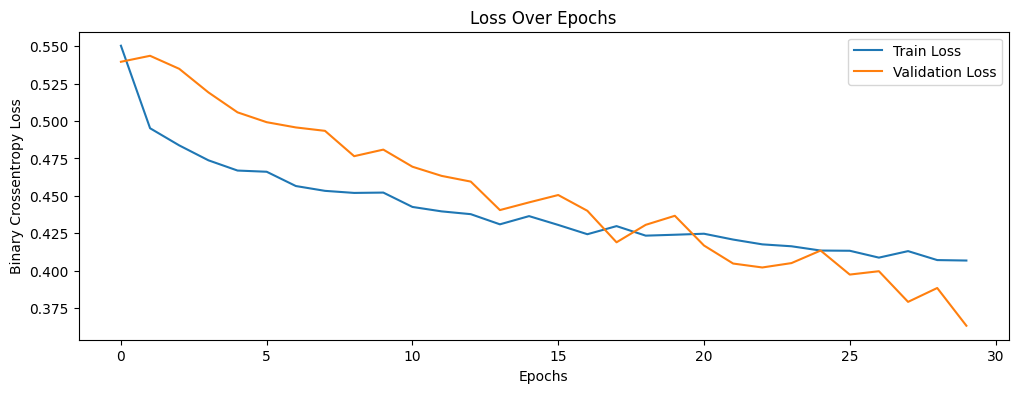

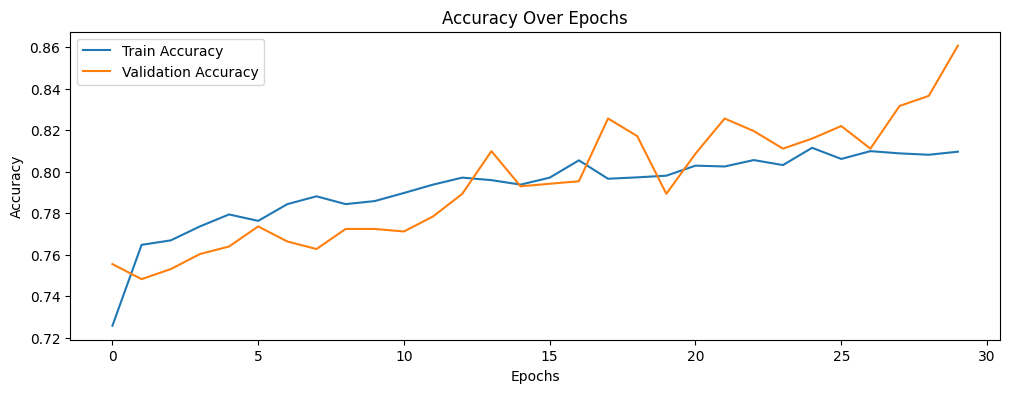

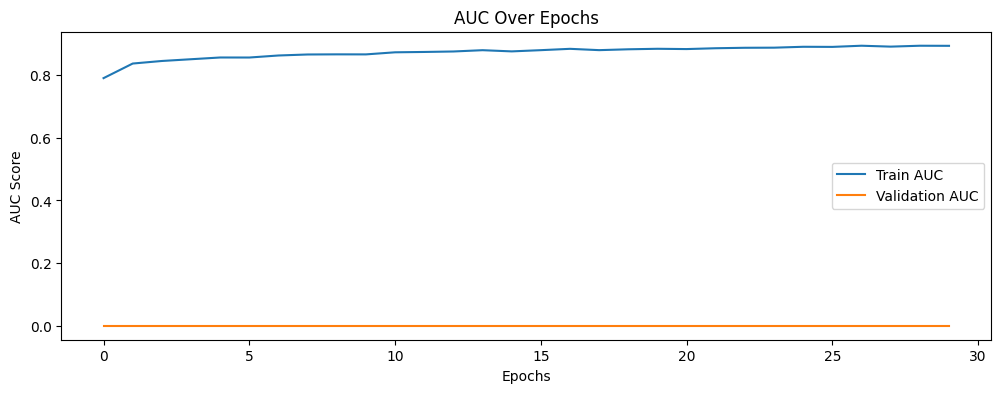

In [11]:
# 📊 Step 6: Training Visualization

# Plot Loss over Epochs
plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.show()

# Plot Accuracy over Epochs
plt.figure(figsize=(12,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot AUC over Epochs
plt.figure(figsize=(12,4))
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


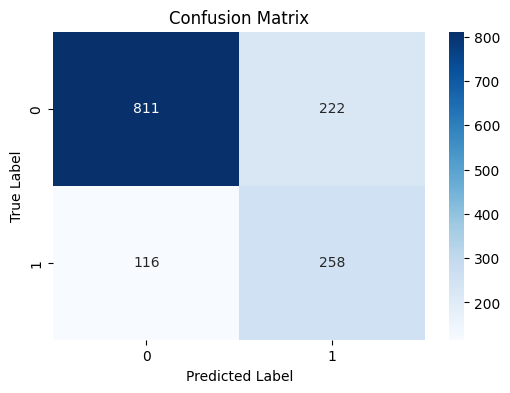

              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1033
           1       0.54      0.69      0.60       374

    accuracy                           0.76      1407
   macro avg       0.71      0.74      0.72      1407
weighted avg       0.79      0.76      0.77      1407



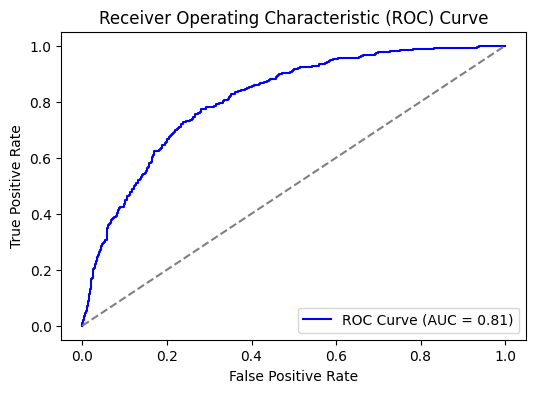

In [12]:
# 📉 Step 7: Evaluation on Test Data

# Predict probabilities on test set
y_probs = model.predict(X_test)

# Convert probabilities to binary labels (threshold=0.5)
y_pred = (y_probs > 0.5).astype(int)

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print detailed classification report (Precision, Recall, F1-score, Accuracy)
print(classification_report(y_test, y_pred))

# Plot ROC Curve and calculate AUC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [13]:
# ✅ Step 8: Save Model and Training History for Reproducibility

# Save the trained model
model.save('churn_model_tf.h5')

# Save training history to CSV
pd.DataFrame(history.history).to_csv('training_history.csv', index=False)

C:\Users\KIIT\AppData\Local\Temp\ipykernel_9480\2043054363.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis')


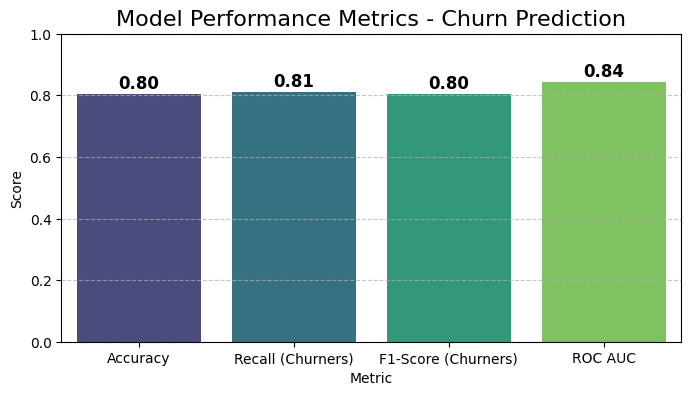

In [18]:
# Create bar chart data
metrics = ['Accuracy', 'Recall (Churners)', 'F1-Score (Churners)', 'ROC AUC']
values = [0.804, 0.81, 0.804, 0.842]

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x=metrics, y=values, palette='viridis')
plt.ylim(0, 1.0)
plt.title('Model Performance Metrics - Churn Prediction', fontsize=16)
plt.ylabel('Score')
plt.xlabel('Metric')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold', fontsize=12)

plt.show()